# Final Project


I made an algorithm that takes an audio file as an input and returns a list instructing the user how to play the input on the guitar. The program only works for one time point; that is, it wouldn't tell the user how to play a whole song over time, but instead how to play a single note or chord.

On a macroscopic level, what's happening can be broken down into the following six steps:

1. Plot the sound file and its Fouier Transform
1. Based off the Fourier Transform data, find the fundamental frequencies and ignore resonant harmonic frequencies which aren't actually being played
1. After finding the frequencies, assign them to a note number; 0 being the lowest note playable and 47 being the highest (assuming a 4-octave guitar)
1. Now that we've found the note numbers corresponding to each frequency, we find how many different places we can play that note on the guitar and return all the positions (since most notes can be played on different positions on different strings).
1. Then, we get all the feasible and complete note arrangements. When I say feasible, I mean to eliminate (for example) arrangements that involve playing 2 notes on one string simultaneously, which is impossible. When I say complete, I mean that the returned arrangements should have instructions to play all of our frequencies, not just 4 ways of playing the same note.
1. Finally, given this list of feasible note combinations, we'll need to find which one is the most comfortable to play. For that, we find the cumulative distance our fingers will be away from one another (measured by string and fret numbers). Whichever one has the smallest cumulative distance will be our optimal chord arrangement, which we'll return.

Now, I'll annotate my steps in building this program.

First, I import all the libraries I'll need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.fftpack import fft, fftfreq
from scipy.io import wavfile as wav
from operator import itemgetter
from heapq import nlargest

## Part 1: Fourier Analysis

Next, I'll walk through the Fourier analysis. For this example, I'll take our audio sample as a single G note played on my accoustic guitar (recorded using my computer's microphone and Garageband). 

We begin by taking the sample rate and the audio data, and then plotting it. I'm plotting the time interval [1s,1.5s] by beginning the index number `samplerate` and ending at `1.5*samplerate`.

(131008, 2)


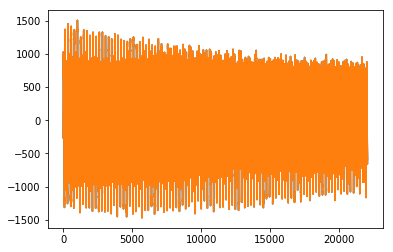

In [2]:
samplerate, data = wav.read('G-Note.wav')
print(data.shape)
plt.plot(data[samplerate:int(1.5*samplerate)])

Our wav file is in stereo, as indicated by the 2 in the `print(data.shape)` statement. So, to simplify our calculations, I'll get just one half of the signal to convert it to mono.

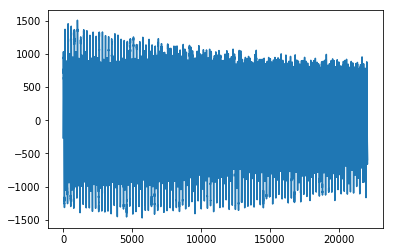

In [3]:
monoData=data[:,0]
newData=monoData[samplerate:int(1.5*samplerate)]
plt.plot(newData)

Next, we'll compute our fourier transform. I'm using `fft` because it's faster and more practical than coding up my own DFT. I make the `freqs` array have the same length as fftabs to ensure they have the same shape for plotting.

To change to frequency space, we plot our frequency values on the x values and their contribution to the signal (that is, their coefficients $a_n$ and $b_n$) on the y axis to see which frequencies contribute to the signal.

Observe how, when we plot this single note, we get multiple frequency spikes. This indicates harmonic frequencies, which complicates our work slightly. We can't simply get all the values above 0 as our notes. However, the issue is manageable because the strengths of the harmonic frequencies in the examples I'll analyze diminish explonentially. So, all the values within roughly 50% of our peak value are likely fundamental frequencies, and all the values below are harmonics. We'll use this fact in our `fundamentalFrequencies` function later.

It's also worth noting that the returned frequencies from the `fft` are exactly double what they should be, which is no problem since double the frequency is just an octave. So, later we'll divide the returned frequencies by 2 to get our correct ocatves.

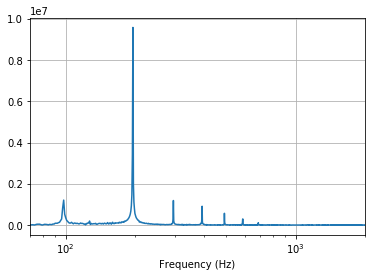

In [9]:
datafft = fft(newData)
fftabs = abs(datafft)
freqs = fftfreq(len(fftabs),1/samplerate)

plt.xlim( [70, 2000] )
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot((freqs[:int(freqs.size/2)])*.5,fftabs[:int(freqs.size/2)])

Now, I'll repeat the above steps for a more complicated 4-note Cadd9 chord played on a midi keyboard in Garageband.

(262080, 2)


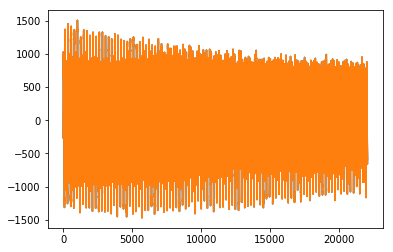

In [5]:
samplerateCadd9, Cadd9data = wav.read('Cadd9.wav')
print(Cadd9data.shape)
plt.plot(data[samplerate:int(1.5*samplerate)])

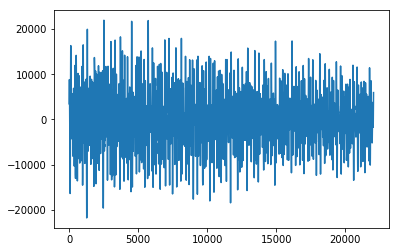

In [6]:
monoDataCadd9=Cadd9data[:,0]
newDataCadd9=monoDataCadd9[samplerateCadd9:int(1.5*samplerateCadd9)]
plt.plot(newDataCadd9)

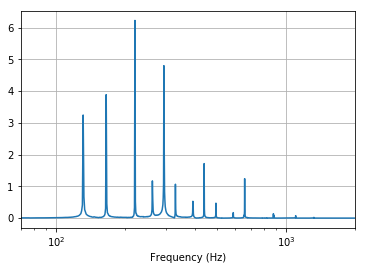

In [10]:
datafftCadd9 = fft(newDataCadd9)
#Get the absolute value of real and complex component:
fftabsCadd9 = abs(datafftCadd9)
freqsCadd9 = fftfreq(len(fftabsCadd9),1/samplerateCadd9)

plt.xlim( [70, 2000] )
plt.xscale( 'log' )
plt.grid( True )
plt.xlabel( 'Frequency (Hz)' )
plt.plot((freqsCadd9[:int(freqsCadd9.size/2)])*(.5),fftabsCadd9[:int(freqsCadd9.size/2)]/(10**7))
plt.yscale("linear")

Again, we see harmonic frequencies in our sample data. However, their magnitudes are all well below those of the fundamental frequencies, so the task of sorting out which is which is relatively straighforward.

## Part 2: Converting Fourier Data into Guitar Data

Now that we have essentially 2 lists, one of frequencies and one of magnitudes corresponding to those frequencies, we will attempt to figure out which frequencies matter. Then, we'll convert those frequencies into notes and subsequently possible fret numbers.

We'll start by assigning each frequency a note number. I got a list online of all the frequencies a guitar can play, listed in order form lowest to highest. To ensure continuity, I designed this to round each fequency to the nearest note. This accounts for slight tuning issues. So, whichever of the note frequencies our given frequency is closest to, it will assign that note number to our frequency.

Additionally, if our frequency is unplayable on the guitar because it fall out of the frequency range, we return -1.

Finally I added the first and last elements of `noteFrequencies`. Those frequencies can't be played on the guitar, but they allow for the case where our given note is tuned slightly above the highest pitch or below the lowest.

So our output is a unique index linking the given frequency and how it is played on the guitar.

In [11]:
noteFrequencies=[78,82.41,87.31,92.50,98.00,103.8,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6,880.0,932.3,987.8,1047,1109,1175,1245,1319,1350]

def noteNumberAssigner(frequency):
    
    noteNumber=None
    for i in range(1,len(noteFrequencies)-1):
        if (frequency > np.average([noteFrequencies[i-1],noteFrequencies[i]])) and (frequency < np.average([noteFrequencies[i],noteFrequencies[i+1]])):
            noteNumber = i-1
    
    #I added this condition in case the given frequency falls out of the playable range on the guitar. 
    #If that's the case, we return -1.
    if noteNumber==None:
        noteNumber=-1
    
    return noteNumber
noteNumberAssigner(196)

15

Now that we have our `noteNumberAssigner` algorithm, we can go about distinguishing between our fundamental frequencies and our harmonics.

In [12]:
def fundamentalFrequencies(fft,freqs,qualify=0.5):
    #This is our threshold which determines whether or not the frequencies are harmonics or fundamental.
    #The undelrying assumption is that the strongest signal is a fundamental frequency
    #I let the user set the height of our threshold
    threshold=qualify*max(fft[:int(freqs.size/2)])
    
    #We'll create a set of notes to eliminate redundancy. This is useful if the peak in our
    #fourier plot has many points all near the peak. When getting all the value above our threshold, they would all come up
    #and register as different notes, even though they're all of the same frequency. So, to avoid repetition, we'll
    #use a set to prevent that.
    notes=set()
    
    #An array for the qualifying FFT values
    fftVals=[]
    
    #Corresponding frequency values
    freqVals=[]
    
    #Corresponding indices
    indices=[]
   
    #The final array we'll use to calculate our notes
    freqValsFinal=[]
    
    #We loop over our entire frequencies and fft values arrays. Note that we've contructed them to be the same length
    for i in range(0,int(freqs.size/2)):
        #This condition filters out all of the fft values that don't pass the threshold. So, freqVals only has 
        #the fundamental frequencies
        if fft[i]>threshold:
            fftVals.append(fft[i])
            freqVals.append(freqs[i])
            indices.append(i)
    #This condition exists for the case when we either have harmonics that are strong enough to interfere with 
    #the fundamentals (e.g. if our chord has been ringing for some time, the fundamentals might decay faster
    #than the harmonics) or when the chord being played has more than 6 notes, which is totally concievable 
    #when analyzing a piano chord, for instance,
    if len(freqVals)>6:
        dominantFreqs = nlargest(6, enumerate(fftVals), itemgetter(1))
        #print(dominantFreqs)
        for value in dominantFreqs:
            index=value[0]
            #print(index)
            freqValsFinal.append(freqVals[index])
    #If we have fewer than 7 notes, then we can just set our final frequencies array to our original freqVals
    else:
        freqValsFinal=freqVals
        
    #Now, the usefulness of the set becomes clear. We assign a note to each frequency whose strength made it
    #past the threshold. Then, to preven double-counting, we make it a set.
    #Note that we divide all the frequencies by 2 before assigning the notes.
    for j in range(0,len(freqValsFinal)):
        if noteNumberAssigner(freqValsFinal[j]/2)!=-1:
            notes.add(noteNumberAssigner(freqValsFinal[j]/2))
    #We return a set of note numbers
    return notes

Now, we'll implement our `fundamentalFrequencies` function on our two examples to see what they return.

In [13]:
GNote=fundamentalFrequencies(fftabs,freqs)
GNote

{15}

In [14]:
Cadd9Chord=fundamentalFrequencies(fftabsCadd9,freqsCadd9)
Cadd9Chord

{8, 12, 17, 22}

These are indeed the correct note numbers for each sample! Now, the next task is finding out all the ways we can play these notes on the guitar. For that, we'll use the `noteAssigner` function, which takes in a note number and returns a list of tuples, each of the structure `(noteNumber, [stringNumber, fretNumber])`

In [15]:
def noteAssigner(noteNumber):
    
    #recall from our noteNumberAssigner function that if a frequency couldn't be played on the guitar,
    #we return -1. So, this reflects that it's impossible to play the given note.
    if noteNumber == -1:
        return [(-1,[-1,-1])]
    note=[]
    noteFinal=[]
    #Every 5 frets, we can play a given note on the next string, with the exception of the 
    #2 highest strings. So, we can play a low a on the 5th fret of the E string
    #or on the 0th fret of the A string, for instance
    numStrings = int(noteNumber/5)
    
    #On the lowest string, the fret we choose is just the note number, since the note number increases
    #with the fret number
    
    fretNumber = noteNumber%5
    #this is our index we'll loop over. We want to find how to play the note on all strings, hence the numStrings+1
    i=numStrings+1
    
    while i>-1:
        #We have 6 strings, so 6-i gives us the string number for this particular way of playing the note,
        #Then, for the highest string we should have the smallest fret number (since higher frets 
        #leads to higher pitches). Then, for the next lower string, we would play the same note 5 frets
        #higher, hence the 5*numStrings-i term. Note that this will return a list of tuples, where
        #the tuples indicate
        note.append((noteNumber, [6-i,fretNumber+5*(numStrings-i)]))
        i-=1
    
    #Now, the two strings that are highest in pitch (1 and 2) are tuned such that they're offset by 1 fret; that is,
    #playing a note on the 2nd string only requires us to move 4 frets up to play the same note on the third string
    #So, if we can play the given note on either of the top strings, then we'll add the fret number by 1.
    for j in note:
        if j[1][0]==2 or j[1][0]==1:
            j[1][1]+=1
    
    #Finally, we're assuming a 24-fret guitar. So, we want to eliminate all coordinates in the note list 
    #that tell us to play higher. For instance, if we input note 41, we're not going to be able to play it on the
    #6th, 5th, or 4th strings, since the fret number will be above 24.
    #So, this function essentially filters out infeaisble arrangements and adds them to noteFinal
    for k in note:
        if k[1][1]<=24 and k[1][1]>=0 and k[1][0]>0:
            noteFinal.append(k)
    
    
    #Now, we return noteFinal
    return noteFinal





It's worth noting that in this convention, the lowest string is #6 and the highest is #1.

Now, let's use our noteAssigner of our G-Note and Cadd9Chord samples from before.

In [16]:
noteAssigner(15)

[(15, [3, 0]), (15, [4, 5]), (15, [5, 10]), (15, [6, 15])]

In [17]:
waysToPlay=[]
for c in Cadd9Chord:
    waysToPlay.append(noteAssigner(c))
waysToPlay

[[(8, [5, 3]), (8, [6, 8])],
 [(17, [3, 2]), (17, [4, 7]), (17, [5, 12]), (17, [6, 17])],
 [(12, [4, 2]), (12, [5, 7]), (12, [6, 12])],
 [(22, [2, 3]), (22, [3, 7]), (22, [4, 12]), (22, [5, 17]), (22, [6, 22])]]

This is indeed all the ways to play the given notes on the guitar! So, we'v successfully converted our Fourier data into usable guitar data. Now, we need to construct and otpimize our final chords.

## Part 3: Chord Construction and Optimization

We'll begin with chord construction by taking the list of notes and finding all the combinations of those notes. Then, we'll filter out all of the infeasible and redundant chords.

In [24]:
def noteCombinations(noteSet):
    
    playingOptions=[]
    
    #Get the number of distinct notes. Will be important later
    numNotes=len(noteSet)
    #This is now a list of note numbers
    noteList=list(noteSet)
    
    #Now, we find all the ways of playing every note. So, playingOptions is a list of tuples
    
    for i in noteList:
        playingOptions+=(noteAssigner(i))
    #We find all the possible combinations of those notes. Most of these
    #will be thrown out due to infeasibility or incompleteness
    allCombos=list(combinations(playingOptions,numNotes))
    
    #Now we create our array that will contain only complete chords; that is,
    #we won't have one note played twice
    noRedundancy=[]
    
    for combination in allCombos:
        #we create a set to find distinct notes
        distinctNotes=set()
        for j in combination:
            distinctNotes.add(j[0])
        #if we have a 4-note chord, we should expect to see 4 distinct notes in our combination.
        #That's what this condition tests for
        if len(distinctNotes) == numNotes:
            noRedundancy.append(combination)
    #Now, all that's left is getting the feasible options, meaning
    #we must eliminate suggestions where we play 2 notes on the same string.
    finalPossibilities=[]

    for arrangement in noRedundancy:
        #We want all the strings to be different, menaing we'll play n notes on n different strings
        distinctStrings=set()
        for k in arrangement:
            distinctStrings.add(k[1][0])
        if len(distinctStrings)==numNotes:
            finalPossibilities.append(arrangement)
    returnedChords=[]
    
    #Finally, we'll sort all the chords to make our chordOptimizer's job easier
    for possibility in finalPossibilities:
        sortedChord=sorted(possibility,key=itemgetter(1))
        returnedChords.append(sortedChord)

    
    return returnedChords
    
    

Now, let's test the `noteCombinations` program on our Cadd9 chord:

In [19]:
optionsCadd9=noteCombinations(Cadd9Chord)
optionsCadd9

[]


[[(22, [2, 3]), (17, [3, 2]), (12, [4, 2]), (8, [5, 3])],
 [(17, [3, 2]), (12, [4, 2]), (8, [5, 3]), (22, [6, 22])],
 [(22, [2, 3]), (17, [3, 2]), (8, [5, 3]), (12, [6, 12])],
 [(17, [3, 2]), (22, [4, 12]), (8, [5, 3]), (12, [6, 12])],
 [(22, [2, 3]), (17, [4, 7]), (8, [5, 3]), (12, [6, 12])],
 [(22, [3, 7]), (17, [4, 7]), (8, [5, 3]), (12, [6, 12])],
 [(22, [2, 3]), (12, [4, 2]), (8, [5, 3]), (17, [6, 17])],
 [(22, [3, 7]), (12, [4, 2]), (8, [5, 3]), (17, [6, 17])],
 [(22, [2, 3]), (17, [3, 2]), (12, [4, 2]), (8, [6, 8])],
 [(17, [3, 2]), (12, [4, 2]), (22, [5, 17]), (8, [6, 8])],
 [(22, [2, 3]), (17, [3, 2]), (12, [5, 7]), (8, [6, 8])],
 [(17, [3, 2]), (22, [4, 12]), (12, [5, 7]), (8, [6, 8])],
 [(22, [2, 3]), (17, [4, 7]), (12, [5, 7]), (8, [6, 8])],
 [(22, [3, 7]), (17, [4, 7]), (12, [5, 7]), (8, [6, 8])],
 [(22, [2, 3]), (12, [4, 2]), (17, [5, 12]), (8, [6, 8])],
 [(22, [3, 7]), (12, [4, 2]), (17, [5, 12]), (8, [6, 8])]]

As we can see, every posisbility contains all 4 notes in the chord, and none of them require us to play 2 notes on the same string! 

Now the final step is to get the best chord, meaning the one that invloves the least finger stretching. I calculated finger stretching by taking the difference in string and fret numbers of consecutive notes in the chord, and then summing the absolute values of differences over the entire chord. That way, we get a measure of the total distance our hand has to traverse to play the chord.

One exception I made is for when the string's fret number is 0, since 0 indicates an open string. You don't need to fret an open string, so those were not included in the sum, sicne they don't contribute to finger stretch.

In [20]:
def chordOptimizer(chordOptions):
    
    #I set the best stretch to some absurdly large value. If our chord's stretch is better, it'll be added to a list
    #of candidates
    bestStretch=10000
    
    optimalChord=[]
    
    
    for chord in chordOptions:
        #Re-set the stretch for each given chord
        stretch=0
        for i in range(0,len(chord)-1):
            #Our condition for an open string
            if chord[i][1][1]==0:
                stretch+=0
            #sum consecutive differences of string numbers and fret numbers
            stretch+=np.abs((chord[i+1][1][1]-chord[i][1][1]))
            stretch+=np.abs((chord[i+1][1][1]-chord[i][1][0]))
        
        #If this chord provides a better playing position than the last, then add it to our list of best arrangements
        if stretch<bestStretch:
            
            bestStretch=stretch
            optimalChord.append(chord)
    
    #Since the best chord of them all is the last element of the list, return the last element.
    if len(optimalChord)==0:
        return -1
    return optimalChord[-1]

And there we have it! Now, let's test the program on our options for the Cadd9

In [21]:
chordOptimizer(optionsCadd9)

[(22, [2, 3]), (17, [3, 2]), (12, [4, 2]), (8, [5, 3])]

I can confirm that this is among the most common ways to play a Cadd9 chord, and for most guitarists the most comfortable. The way to read the output, then is to play the 3rd fret on the 2nd string, 2nd fret on the 3rd string, 2nd fret on the 4th string, and 3rd fret on the 5th string.

## Part 4: Combining to Create one Function

Now, we just need to combine all of the functions we've created to make one large function which takes a wav file as an input and returns the optimal way to play the chord, along with plots of the soundwave and its fourier transform. I added an argument to allow the user to determine when they wanted to analyze the chord in question.

In [22]:
def chordRecognition(soundFile,start=1,end=1.5,qualify=0.5):
    samplerate, data = wav.read(soundFile)
    monoData=data[:,0]
    newData=monoData[int(start*samplerate):int(end*samplerate)]
    
    plt.subplot(121)
    plt.plot(newData)
    
    fftabs = abs(fft(newData))
    freqs = fftfreq(len(fftabs),1/samplerate)

    plt.subplot(122)
    plt.xlim( [70, 1500] )
    plt.xscale( 'log' )
    plt.grid( True )
    plt.xlabel( 'Frequency (Hz)' )
    plt.plot((freqs[:int(freqs.size/2)])*.5,fftabs[:int(freqs.size/2)])
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.6, hspace=0.25,
                    wspace=0.35)    
    
    notes=fundamentalFrequencies(fftabs,freqs,qualify)
    combos=noteCombinations(notes)
    optimal=chordOptimizer(combos)
    
    if optimal==-1:
        return('Sample cannot be played on the guitar')
    
    return optimal


And finally, to test it on some sample data.

First is the G note played on my guitar, then I played a standard C-major chord on a digital grand piano in garageband, and then I played the more complicated, jazzy Cadd9 chord on an electric keyboard, also from garageband.

[(15, [3, 0])]

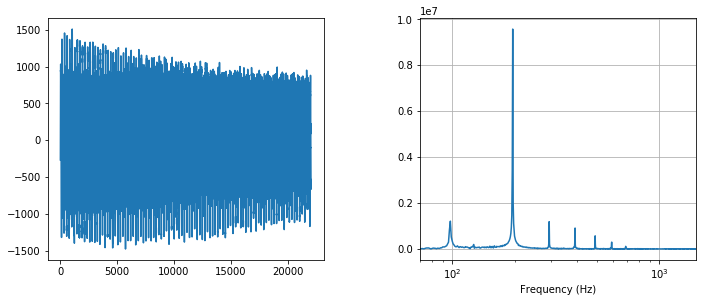

In [25]:
chordRecognition("G-Note.wav")

[(20, [2, 1]), (15, [3, 0]), (12, [4, 2]), (8, [5, 3])]

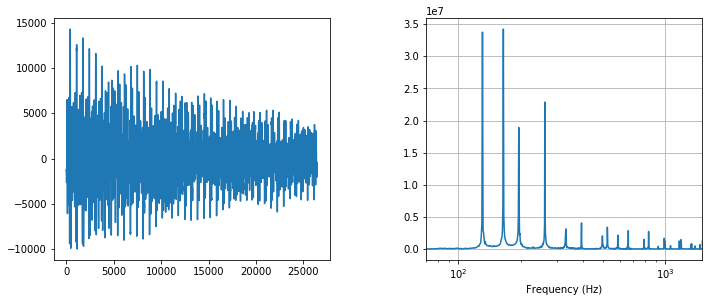

In [26]:
chordRecognition("C-chord.wav",.4,1)

[(22, [2, 3]), (17, [3, 2]), (12, [4, 2]), (8, [5, 3])]

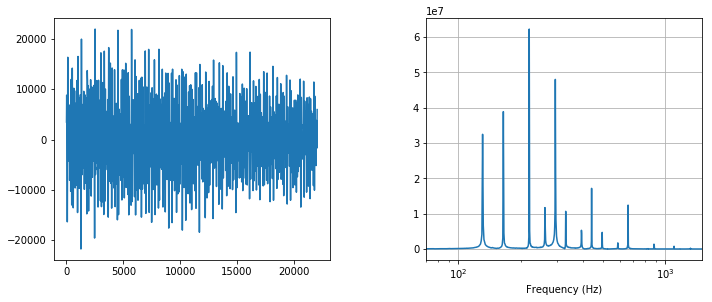

In [27]:
chordRecognition("Cadd9.wav")

## Part 5: Limitations and Areas of Further Work

This algorithm is clearly not perfect; while it works very well for extremely clean, simple audio signals, it works less well for more complex ones. For instance, when recording larger, open guitar chords through my computer microphone, the signal is much more ocmplicated and as a result it's much harder to figure out which notes are fundamental and which are harmonic. The following is the result for a 6-string open e chord.

[(35, [1, 11]), (16, [3, 1]), (12, [4, 2]), (4, [6, 4])]

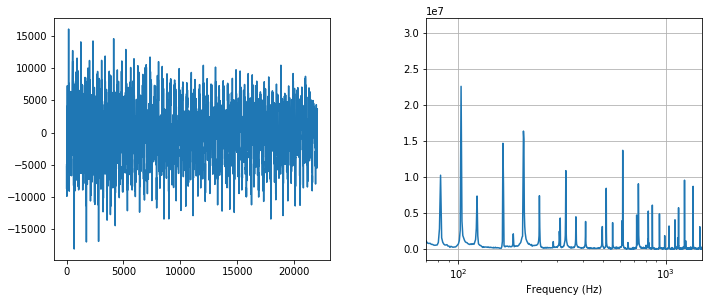

In [28]:
chordRecognition("E-Chord.wav",1,1.5,qualify=0.4)

Just by eye, the fundamental frequencies are much less clear from the fourier transform. So, our relatively simple exponential decay assumption isn't sufficient for sorting out data from noise here. As a result, our program gives us most of the notes of an E major chord, meaning it's not a complete failure. But, it gives some in the wrong octaves and as a result, doesn't give the correct fingering at all.

One potential solution to this problem would be to train the algorithm to recognize noise from signal with a neural network and many audio samples to train it. However, given the time and effort involved in getting a unique audio sample, doing that seems somewhat infeasible, at least for this project.

Another area of further work would be to have this program run over time to tell the user a full chord progression. This could potentially involve splitting up the sample into many pieces, running our chord recognition algorithm, and then printing out the new chord every time the chord changes.

Ultimately then, this program works in a fairly limited capacity; it seems to be best suited for very clean audio signals, preferably from a MIDI or other digital source. I didn't try recording with a higher quality microphone, but I can imagine that would help as well. It also only works for one chord at a time, which diminishes its utility. But, in its niche, the program does as advertised; given an audio file, it returns the instructions to play the chord on the guitar with a good degree of accuracy.

### References:

For help with implementing the FFT:
* https://pythondsp.rob-elder.com/loading-wav-files-and-showing-frequency-response/

For information on audio processing and chord recognition using fourier analysis:
* Christoph Hausner, "Design and Evaluation of a Simple Chord Detection Algorithm" Bachelor's Thesis, University of Passau, 2014, https://www.fim.uni-passau.de/fileadmin/files/lehrstuhl/sauer/geyer/BA_MA_Arbeiten/BA-HausnerChristoph-201409.pdf